In [244]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, Dropdown
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.stats.contingency_tables import Table2x2
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go




In [245]:
# Load data
Cole = pd.read_csv("cole_data.csv")

# Combine all data
all_data = pd.concat([Ohtani, Cole], keys=['Ohtani', 'Cole'], names=['Pitcher'])

In [246]:



Ohtani = pd.read_csv("Ohtani_2018-2023.csv")
Ohtani

# Ensure the 'game_date' column is converted to datetime
Ohtani['game_date'] = pd.to_datetime(Ohtani['game_date'])

# Create a dictionary to store DataFrames for each year
yearly_data = {}

# Loop through the years 2018 to 2023
for year in range(2018, 2024):
    # Filter the DataFrame for the current year
    mask = (Ohtani['game_date'].dt.year == year)
    yearly_data[year] = Ohtani[mask]

    # Optional: Save the DataFrame for the current year to a new CSV file
    yearly_data[year].to_csv(f"Ohtani{year}.csv", index=False)

# Access each year's data
data_2018 = yearly_data[2018]
data_2019 = yearly_data[2019]  # He didn't play this season
data_2020 = yearly_data[2020]
data_2021 = yearly_data[2021]
data_2022 = yearly_data[2022]
data_2023 = yearly_data[2023]


pitchers = {
    '2018': data_2018,
    '2020': data_2020,
    '2021': data_2021,
    '2022': data_2022,
    '2023': data_2023

}

data_2018 = pd.DataFrame(data_2018)
data_2020 = pd.DataFrame(data_2020)
data_2021 = pd.DataFrame(data_2021)
data_2022 = pd.DataFrame(data_2022)
data_2023 = pd.DataFrame(data_2023)



In [247]:
strike_descriptions = ['strike', 'swinging_strike', 'called_strike', 'swinging_strike_blocked', 'foul', 'foul_tip', 'foul_bunt']
ball_descriptions = ['ball', 'blocked_ball', 'hit_by_pitch', 'foul_bunt']
hit_into_play_descriptions = ['hit_into_play']

In [248]:
Ohtani_pitch_type_table = Ohtani['pitch_type'].value_counts().reset_index()
Ohtani_pitch_type_table.columns = ['pitch_type', 'count']

Ohtani_pitch_type_table

pitch_type  count
0         FF   2734
1         ST   2397
2         FS   1014
3         FC    811
4         CU    428
5         SI    223
6         SL     74
7         CS      1

In [249]:
Cole_pitch_type_table = Cole['pitch_type'].value_counts().reset_index()
Cole_pitch_type_table.columns = ['pitch_type', 'count']

Cole_pitch_type_table

pitch_type  count
0         FF   1739
1         SL    683
2         KC    396
3         CH    233
4         FC    230

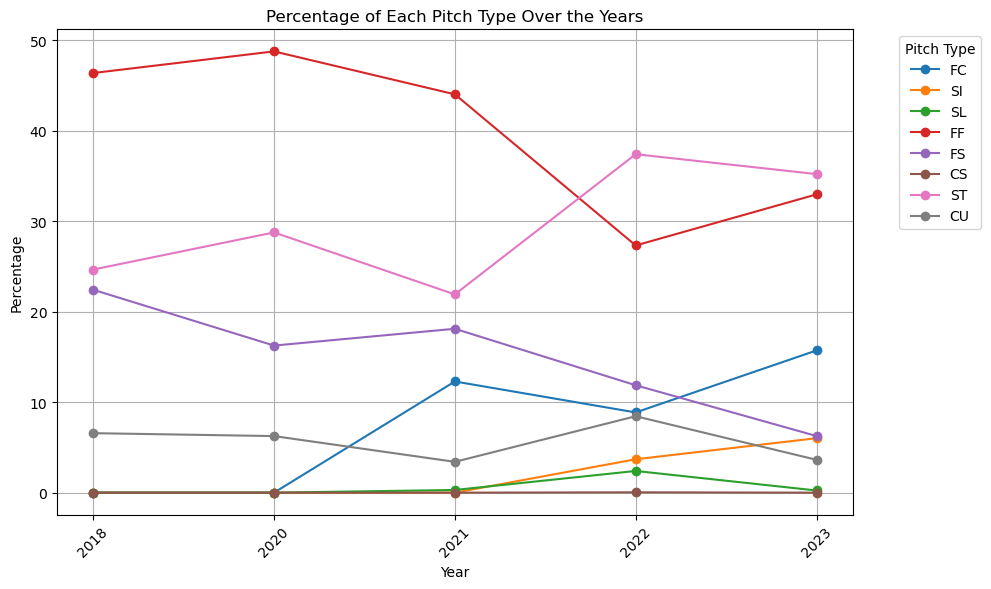

In [331]:


data_frames = {'2018': data_2018, '2020': data_2020, '2021': data_2021, '2022': data_2022, '2023': data_2023}

# Create an empty DataFrame to hold the contingency table
contingency_table = pd.DataFrame()

# Get a complete list of all pitch types across all years
all_pitch_types = set()
for df in data_frames.values():
    all_pitch_types.update(df['pitch_type'].dropna().unique())  # Drop nan values
all_pitch_types = list(all_pitch_types)

# Initialize the contingency table with zeros for all years and pitch types
years = list(data_frames.keys())
contingency_table = pd.DataFrame(0, index=years, columns=all_pitch_types)

# Process each year's data
for year, df in data_frames.items():
    pitch_counts = df['pitch_type'].value_counts()  # Get the counts of each pitch type for the current year
    for pitch_type, count in pitch_counts.items():
        contingency_table.at[year, pitch_type] = count

# Calculate percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plotting
plt.figure(figsize=(10, 6))
for pitch_type in contingency_table_percentage.columns:
    plt.plot(contingency_table_percentage.index, contingency_table_percentage[pitch_type], label=pitch_type, marker='o')

plt.title('Percentage of Each Pitch Type Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [333]:


data_frames = {'2018': data_2018, '2020': data_2020, '2021': data_2021, '2022': data_2022, '2023': data_2023}

# Function to update the output based on the dropdown
def view_data(year):
    df = data_frames[year]
    pitch_type_counts = df['pitch_type'].value_counts().reset_index()
    pitch_type_counts.columns = ['Pitch Type', 'Count']
    # Calculate the percentage of each pitch type
    total_pitches = pitch_type_counts['Count'].sum()
    pitch_type_counts['Percentage'] = (pitch_type_counts['Count'] / total_pitches * 100).round(2).astype(str) + '%'
    return pitch_type_counts

# Create a dropdown and output widgets
dropdown = widgets.Dropdown(options=['2018', '2020', '2021', '2022', '2023'], description='Year:')
output = widgets.Output()

# Link the function to changes in the dropdown
def dropdown_eventhandler(change):
    output.clear_output()
    with output:
        display(view_data(change.new))

dropdown.observe(dropdown_eventhandler, names='value')

# Display the widgets
display(dropdown, output)



Dropdown(description='Year:', options=('2018', '2020', '2021', '2022', '2023'), value='2018')

Output()

In [251]:

# Define strike and non-strike descriptions
strike_descriptions = ['strike', 'swinging_strike', 'called_strike', 'swinging_strike_blocked', 'foul', 'foul_tip', 'foul_bunt']
non_strike_descriptions = ['ball', 'blocked_ball', 'hit_by_pitch', 'foul_bunt', 'hit_into_play']

data_frames = {'2018': data_2018, '2020': data_2020, '2021': data_2021, '2022': data_2022, '2023': data_2023}

def view_data(year):
    df = data_frames[year]
    pitch_type_counts = df['pitch_type'].value_counts().reset_index()
    pitch_type_counts.columns = ['Pitch Type', 'Count']

    # Calculate the total number of pitches
    total_pitches = pitch_type_counts['Count'].sum()

    # Calculate the percentage of each pitch type
    pitch_type_counts['Percentage'] = (pitch_type_counts['Count'] / total_pitches * 100).round(2).astype(str) + '%'

    # Calculate the strike and non-strike percentages for each pitch type
    strike_percentages = []
    non_strike_percentages = []
    for pitch_type in pitch_type_counts['Pitch Type']:
        pitch_df = df[df['pitch_type'] == pitch_type]
        strike_count = pitch_df[pitch_df['description'].isin(strike_descriptions)]['description'].count()
        non_strike_count = pitch_df[pitch_df['description'].isin(non_strike_descriptions)]['description'].count()
        total_pitch_type_count = pitch_df['description'].count()
        
        strike_percentage = (strike_count / total_pitch_type_count * 100).round(2) if total_pitch_type_count > 0 else 0
        non_strike_percentage = (non_strike_count / total_pitch_type_count * 100).round(2) if total_pitch_type_count > 0 else 0
        
        strike_percentages.append(str(strike_percentage) + '%')
        non_strike_percentages.append(str(non_strike_percentage) + '%')
    
    pitch_type_counts['Strike Percentage'] = strike_percentages
    pitch_type_counts['Non-Strike Percentage'] = non_strike_percentages

    return pitch_type_counts

# Create a dropdown and output widgets
dropdown = widgets.Dropdown(options=['2018', '2020', '2021', '2022', '2023'], description='Year:')
output = widgets.Output()

# Link the function to changes in the dropdown
def dropdown_eventhandler(change):
    output.clear_output()
    with output:
        display(view_data(change.new))

dropdown.observe(dropdown_eventhandler, names='value')

# Display the widgets
display(dropdown, output)




Dropdown(description='Year:', options=('2018', '2020', '2021', '2022', '2023'), value='2018')

Output()

In [252]:


# Ensure the 'game_date' column is converted to datetime
Ohtani['game_date'] = pd.to_datetime(Ohtani['game_date'])

# Remove rows with NaN values in essential columns
Ohtani = Ohtani.dropna(subset=['pitch_type', 'release_pos_x', 'release_pos_z', 'release_speed', 'stand', 'p_throws', 'type'])

# Remove the year 2019
Ohtani = Ohtani[Ohtani['game_date'].dt.year != 2019]

# Create a dictionary to store DataFrames for each year
yearly_data = {}

# Loop through the years 2018 to 2023 (excluding 2019)
for year in range(2018, 2024):
    if year != 2019:
        # Filter the DataFrame for the current year
        mask = (Ohtani['game_date'].dt.year == year)
        yearly_data[year] = Ohtani[mask]

# Define a function to plot the heatmaps including the batter's stand
def plot_ohtani_heatmaps(pitch_type, year):
    plt.figure(figsize=(18, 12))
    
    # Get data for the specified year
    data = yearly_data.get(year, pd.DataFrame())
    
    if data.empty or pitch_type not in data['pitch_type'].unique():
        plt.title(f'No data for Ohtani - {pitch_type} - {year}')
        plt.show()
        return
    
    # Filter the data for left and right-handed pitches for Ohtani
    ohtani_left_data = data[data['p_throws'] == 'L']
    ohtani_right_data = data[data['p_throws'] == 'R']
    
    # Plot heatmap for left-handed pitches (Left-handed batter)
    if pitch_type in ohtani_left_data['pitch_type'].unique():
        left_data_left_stand = ohtani_left_data[(ohtani_left_data['pitch_type'] == pitch_type) & (ohtani_left_data['stand'] == 'L')]
        if len(left_data_left_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 1)
            sns.kdeplot(x=left_data_left_stand['release_pos_x'], y=left_data_left_stand['release_pos_z'], cmap='Reds', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Left - {year}')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 1)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Left - {year} (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    # Plot heatmap for left-handed pitches (Right-handed batter)
    if pitch_type in ohtani_left_data['pitch_type'].unique():
        left_data_right_stand = ohtani_left_data[(ohtani_left_data['pitch_type'] == pitch_type) & (ohtani_left_data['stand'] == 'R')]
        if len(left_data_right_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 2)
            sns.kdeplot(x=left_data_right_stand['release_pos_x'], y=left_data_right_stand['release_pos_z'], cmap='Reds', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Right - {year}')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 2)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Right - {year} (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    # Plot heatmap for right-handed pitches (Left-handed batter)
    if pitch_type in ohtani_right_data['pitch_type'].unique():
        right_data_left_stand = ohtani_right_data[(ohtani_right_data['pitch_type'] == pitch_type) & (ohtani_right_data['stand'] == 'L')]
        if len(right_data_left_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 3)
            sns.kdeplot(x=right_data_left_stand['release_pos_x'], y=right_data_left_stand['release_pos_z'], cmap='Blues', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Left - {year}')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 3)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Left - {year} (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    # Plot heatmap for right-handed pitches (Right-handed batter)
    if pitch_type in ohtani_right_data['pitch_type'].unique():
        right_data_right_stand = ohtani_right_data[(ohtani_right_data['pitch_type'] == pitch_type) & (ohtani_right_data['stand'] == 'R')]
        if len(right_data_right_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 4)
            sns.kdeplot(x=right_data_right_stand['release_pos_x'], y=right_data_right_stand['release_pos_z'], cmap='Blues', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Right - {year}')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 4)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Right - {year} (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    plt.tight_layout()
    plt.show()

# Create a list of unique pitch types for Ohtani
ohtani_pitch_types = Ohtani['pitch_type'].unique()

# Create a list of years from 2018 to 2023, excluding 2019
years = [2018, 2020, 2021, 2022, 2023]

# Create dropdown widgets for pitch types and years
pitch_type_dropdown = widgets.Dropdown(
    options=ohtani_pitch_types,
    value=ohtani_pitch_types[0],
    description='Pitch Type:',
)

year_dropdown = widgets.Dropdown(
    options=years,
    value=years[0],
    description='Year:',
)

# Use ipywidgets interact to update heatmaps based on dropdown selections
interact(plot_ohtani_heatmaps, pitch_type=pitch_type_dropdown, year=year_dropdown)


interactive(children=(Dropdown(description='Pitch Type:', options=('FF', 'ST', 'FS', 'SI', 'CU', 'FC', 'SL', '…

<function __main__.plot_ohtani_heatmaps(pitch_type, year)>

In [254]:
# Function to create a 3D scatter plot
def plot_3d_pitch_distribution(pitch_type, year):
    data = yearly_data.get(year, pd.DataFrame())
    player_name = 'Ohtani'
    
    if data.empty or pitch_type not in data['pitch_type'].unique():
        print(f'No data for Ohtani - {pitch_type} - {year}')
        return
    
    fig = go.Figure()

    # Filter data for the selected pitch type and hand
    left_strike_data = data[(data['pitch_type'] == pitch_type) & (data['p_throws'] == 'L') & (data['type'] == 'S')]
    left_non_strike_data = data[(data['pitch_type'] == pitch_type) & (data['p_throws'] == 'L') & (data['type'] == 'B')]
    right_strike_data = data[(data['pitch_type'] == pitch_type) & (data['p_throws'] == 'R') & (data['type'] == 'S')]
    right_non_strike_data = data[(data['pitch_type'] == pitch_type) & (data['p_throws'] == 'R') & (data['type'] == 'B')]
    
    # Add trace for left-handed strikes
    fig.add_trace(go.Scatter3d(
        x=left_strike_data['release_pos_x'],
        y=left_strike_data['release_pos_z'],
        z=left_strike_data['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='green',
            opacity=0.8
        ),
        name=f'{pitch_type} - Left Handed - Strike'
    ))

    # Add trace for left-handed non-strikes
    fig.add_trace(go.Scatter3d(
        x=left_non_strike_data['release_pos_x'],
        y=left_non_strike_data['release_pos_z'],
        z=left_non_strike_data['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='red',
            opacity=0.8
        ),
        name=f'{pitch_type} - Left Handed - Non-Strike'
    ))

    # Add trace for right-handed strikes
    fig.add_trace(go.Scatter3d(
        x=right_strike_data['release_pos_x'],
        y=right_strike_data['release_pos_z'],
        z=right_strike_data['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='green',
            opacity=0.8
        ),
        name=f'{pitch_type} - Right Handed - Strike'
    ))

    # Add trace for right-handed non-strikes
    fig.add_trace(go.Scatter3d(
        x=right_non_strike_data['release_pos_x'],
        y=right_non_strike_data['release_pos_z'],
        z=right_non_strike_data['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='red',
            opacity=0.8
        ),
        name=f'{pitch_type} - Right Handed - Non-Strike'
    ))

    # Update the layout
    fig.update_layout(
        title=f'3D Pitch Speed Distribution for {player_name} ({year}) - {pitch_type}',
        scene=dict(
            xaxis_title='Release Position X',
            yaxis_title='Release Position Z',
            zaxis_title='Release Speed'
        ),
        legend_title="Pitch Type, Hand, and Outcome"
    )
    
    fig.show()

# Create a list of unique pitch types for Ohtani
ohtani_pitch_types = Ohtani['pitch_type'].unique()

# Create a list of years from 2018 to 2023, excluding 2019
years = [2018, 2020, 2021, 2022, 2023]

# Create dropdown widgets for pitch types and years
pitch_type_dropdown = widgets.Dropdown(
    options=ohtani_pitch_types,
    value=ohtani_pitch_types[0],
    description='Pitch Type:',
)

year_dropdown = widgets.Dropdown(
    options=years,
    value=years[0],
    description='Year:',
)

# Use ipywidgets interact to update 3D plot based on dropdown selections
interact(plot_3d_pitch_distribution, pitch_type=pitch_type_dropdown, year=year_dropdown)

interactive(children=(Dropdown(description='Pitch Type:', options=('FF', 'ST', 'FS', 'SI', 'CU', 'FC', 'SL', '…

<function __main__.plot_3d_pitch_distribution(pitch_type, year)>

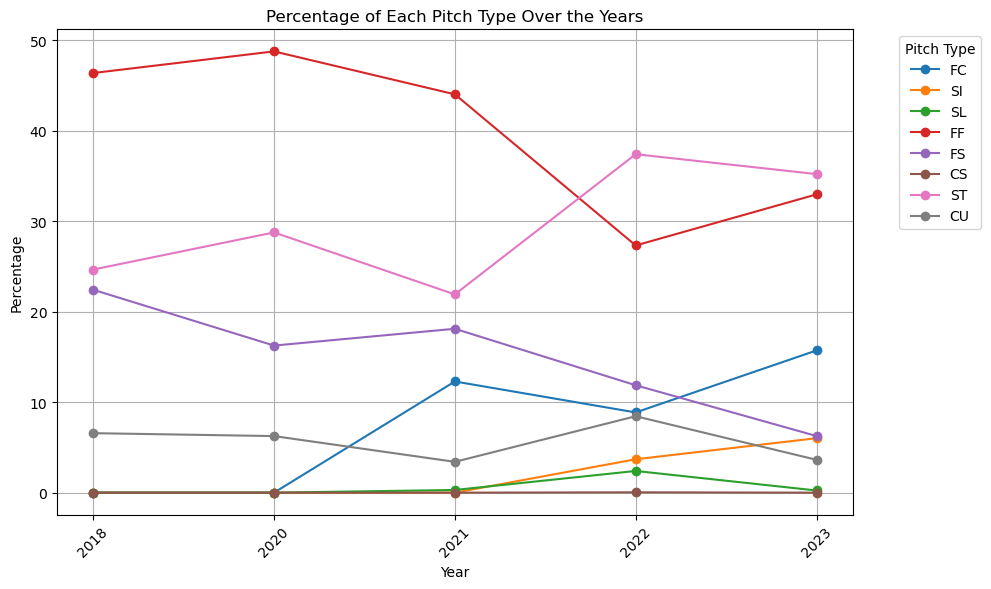

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning:

invalid value encountered in divide



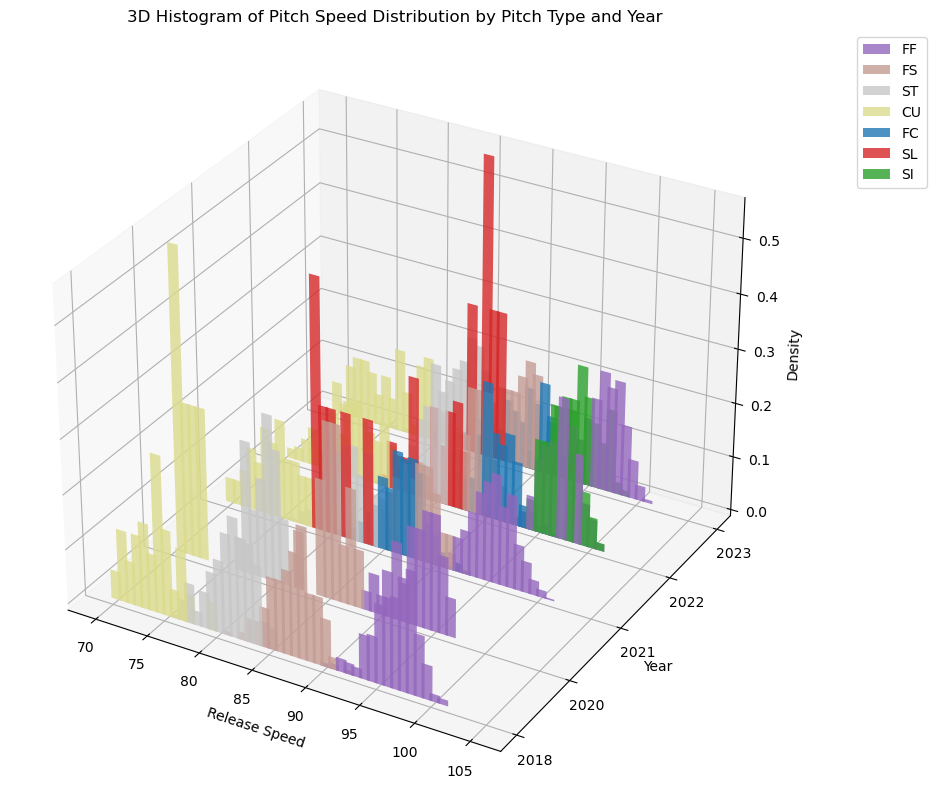

In [257]:

def plot_3d_histogram(pitchers):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    bins = np.linspace(70, 105, 50)

    all_pitch_types = set()
    for df in pitchers.values():
        all_pitch_types.update(df['pitch_type'].unique())
    all_pitch_types = list(all_pitch_types)

    # Create a color map for pitch types
    color_palette = plt.get_cmap('tab20')
    pitch_type_colors = {pt: color_palette(i / len(all_pitch_types)) for i, pt in enumerate(all_pitch_types)}

    plotted_labels = set()  # Keep track of plotted labels to avoid duplicates

    for i, (year, df) in enumerate(pitchers.items()):
        for pitch_type in all_pitch_types:
            subset = df[df['pitch_type'] == pitch_type]
            if not subset.empty:
                hist, edges = np.histogram(subset['release_speed'], bins=bins, density=True)
                centers = (edges[:-1] + edges[1:]) / 2
                if np.any(hist) and not np.isnan(hist).all():  # Only plot if histogram has non-zero values and is not all NaN
                    ax.bar(centers, hist, zs=i, zdir='y', alpha=0.8, width=1.0,
                           color=pitch_type_colors[pitch_type], label=f'{pitch_type}' if pitch_type not in plotted_labels else "")
                    plotted_labels.add(pitch_type)  # Add the pitch type to the set

    ax.set_xlabel('Release Speed')
    ax.set_ylabel('Year')
    ax.set_zlabel('Density')
    ax.set_yticks(range(len(pitchers)))
    ax.set_yticklabels(pitchers.keys())
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.title('3D Histogram of Pitch Speed Distribution by Pitch Type and Year')
    plt.show()

# Plot the 3D histogram
plot_3d_histogram(pitchers)

In [258]:
# Function to create a 3D scatter plot for strikes and non-strikes
def plot_3d_strike_non_strike(pitch_type, year):
    data = data_frames[str(year)]
    
    if data.empty or pitch_type not in data['pitch_type'].unique():
        print(f'No data for Ohtani - {pitch_type} - {year}')
        return
    
    fig = go.Figure()

    # Filter data for the selected pitch type and outcome
    strike_data = data[(data['pitch_type'] == pitch_type) & (data['type'] == 'S')]
    non_strike_data = data[(data['pitch_type'] == pitch_type) & (data['type'] == 'B')]
    
    # Add trace for strikes
    fig.add_trace(go.Scatter3d(
        x=strike_data['release_pos_x'],
        y=strike_data['release_pos_z'],
        z=strike_data['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='green',
            opacity=0.8
        ),
        name=f'{pitch_type} - Strike'
    ))

    # Add trace for non-strikes
    fig.add_trace(go.Scatter3d(
        x=non_strike_data['release_pos_x'],
        y=non_strike_data['release_pos_z'],
        z=non_strike_data['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='red',
            opacity=0.8
        ),
        name=f'{pitch_type} - Non-Strike'
    ))

    # Update the layout
    fig.update_layout(
        title=f'Strike vs Non-Strike for {pitch_type} in {year}',
        scene=dict(
            xaxis_title='Release Position X',
            yaxis_title='Release Position Z',
            zaxis_title='Release Speed'
        ),
        legend_title="Outcome"
    )
    
    fig.show()

# Create a list of unique pitch types for Ohtani
all_pitch_types = set()
for df in data_frames.values():
    all_pitch_types.update(df['pitch_type'].dropna().unique())  # Ensure NaN values are excluded
all_pitch_types = sorted(all_pitch_types)

# Create dropdown widgets for pitch types and years
pitch_type_dropdown = widgets.Dropdown(
    options=all_pitch_types,
    value=all_pitch_types[0],
    description='Pitch Type:',
)

year_dropdown = widgets.Dropdown(
    options=list(data_frames.keys()),
    value='2018',
    description='Year:',
)

# Use ipywidgets interact to update 3D plot based on dropdown selections
interact(plot_3d_strike_non_strike, pitch_type=pitch_type_dropdown, year=year_dropdown)

interactive(children=(Dropdown(description='Pitch Type:', options=('CS', 'CU', 'FC', 'FF', 'FS', 'SI', 'SL', '…

<function __main__.plot_3d_strike_non_strike(pitch_type, year)>

In [259]:
# Define colors for each year
year_colors = {
    '2018': 'blue',
    '2020': 'orange',
    '2021': 'green',
    '2022': 'red',
    '2023': 'purple'
}

# Function to create a 3D scatter plot for strikes and non-strikes for all years
def plot_3d_strike_non_strike_all_years(pitch_type, outcome):
    fig = go.Figure()

    # Process each year's data
    for year, data in data_frames.items():
        if pitch_type not in data['pitch_type'].unique():
            continue
        
        # Filter data for the selected pitch type and outcome
        filtered_data = data[(data['pitch_type'] == pitch_type) & (data['type'] == outcome)]
        
        # Add trace for the filtered data
        fig.add_trace(go.Scatter3d(
            x=filtered_data['release_pos_x'],
            y=filtered_data['release_pos_z'],
            z=filtered_data['release_speed'],
            mode='markers',
            marker=dict(
                size=5,
                color=year_colors[year],
                opacity=0.8
            ),
            name=f'{pitch_type} - {("Strike" if outcome == "S" else "Non-Strike")} - {year}'
        ))

    # Update the layout
    fig.update_layout(
        title=f'{("Strike" if outcome == "S" else "Non-Strike")} for {pitch_type} (2018-2023)',
        scene=dict(
            xaxis_title='Release Position X',
            yaxis_title='Release Position Z',
            zaxis_title='Release Speed'
        ),
        legend_title="Year"
    )
    
    fig.show()

# Create a list of unique pitch types for Ohtani
all_pitch_types = set()
for df in data_frames.values():
    all_pitch_types.update(df['pitch_type'].dropna().unique())  # Ensure NaN values are excluded
all_pitch_types = sorted(all_pitch_types)

# Create dropdown widgets for pitch types and outcomes
pitch_type_dropdown = widgets.Dropdown(
    options=all_pitch_types,
    value=all_pitch_types[0],
    description='Pitch Type:',
)

outcome_dropdown = widgets.Dropdown(
    options={'Strike': 'S', 'Non-Strike': 'B'},
    value='S',
    description='Outcome:',
)

# Use ipywidgets interact to update 3D plot based on dropdown selections
interact(plot_3d_strike_non_strike_all_years, pitch_type=pitch_type_dropdown, outcome=outcome_dropdown)

interactive(children=(Dropdown(description='Pitch Type:', options=('CS', 'CU', 'FC', 'FF', 'FS', 'SI', 'SL', '…

<function __main__.plot_3d_strike_non_strike_all_years(pitch_type, outcome)>

In [260]:
Ohtani_pitch_type_table['Player'] = 'Ohtani'
Cole_pitch_type_table['Player'] = 'Cole'


# Combining all pitch type tables into one dataframe
combined_data = pd.concat([Ohtani_pitch_type_table, Cole_pitch_type_table])

# Creating a pivot table to show the count of each pitch type for each player
contingency_table = pd.pivot_table(combined_data, values='count', index='pitch_type', columns='Player', fill_value=0)

# Display the contingency table
print(contingency_table)

Player      Cole  Ohtani
pitch_type              
CH           233       0
CS             0       1
CU             0     428
FC           230     811
FF          1739    2734
FS             0    1014
KC           396       0
SI             0     223
SL           683      74
ST             0    2397


In [335]:


# Function to create a 3D scatter plot
def plot_3d_pitch_distribution(data, player_name):
    fig = go.Figure()

    # Unique pitch types
    pitch_types = data['pitch_type'].unique()
    
    # Adding one trace for each pitch type
    for pitch_type in pitch_types:
        subset = data[data['pitch_type'] == pitch_type]
        fig.add_trace(go.Scatter3d(
            x=subset['release_pos_x'],  # or any other suitable variable
            y=subset['release_pos_z'],  # or any other suitable variable
            z=subset['release_speed'],
            mode='markers',
            marker=dict(
                size=5,
                opacity=0.8
            ),
            name=pitch_type
        ))

    # Update the layout
    fig.update_layout(
        title=f'3D Pitch Speed Distribution for {player_name}',
        scene=dict(
            xaxis_title='Release Position X',
            yaxis_title='Release Position Z',
            zaxis_title='Release Speed'
        ),
        legend_title="Pitch Type"
    )
    
    fig.show()

In [343]:
# Plot for each player
plot_3d_pitch_distribution(Ohtani, "Ohtani")

In [345]:
plot_3d_pitch_distribution(Cole, "Cole")

In [347]:


# Function to create a 3D scatter plot for pitch location vs strike outcome
def plot_3d_strike_location(data, player_name):
    # Filter data for strikes and non-strikes
    strikes = data[data['description'].str.contains('strike')]
    non_strikes = data[~data['description'].str.contains('strike')]
    
    fig = go.Figure()

    # Adding strikes
    fig.add_trace(go.Scatter3d(
        x=strikes['release_pos_x'],
        y=strikes['release_pos_z'],
        z=strikes['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='green',  # Green for strikes
            opacity=0.5
        ),
        name='Strikes'
    ))

    # Adding non-strikes
    fig.add_trace(go.Scatter3d(
        x=non_strikes['release_pos_x'],
        y=non_strikes['release_pos_z'],
        z=non_strikes['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='red',  # Red for non-strikes
            opacity=0.5
        ),
        name='Non-Strikes'
    ))

    # Update the layout
    fig.update_layout(
        title=f'{player_name} Pitch Location vs Strike Outcome',
        scene=dict(
            xaxis_title='Release Position X',
            yaxis_title='Release Position Z',
            zaxis_title='Release Speed'
        ),
        legend_title="Pitch Outcome"
    )
    
    fig.show()

# Example usage with player data
plot_3d_strike_location(Ohtani, "Ohtani")
plot_3d_strike_location(Cole, "Cole")

In [349]:


# Update function to handle detailed descriptions
def update_plot(pitch_type, data, player_name):
    fig = go.Figure()
    
    # Filter data for this pitch type
    pitch_data = data[data['pitch_type'] == pitch_type]

    # Detailed descriptions
    strike_descriptions = ['strike', 'swinging_strike', 'called_strike', 'swinging_strike_blocked', 'foul', 'foul_tip', 'foul_bunt']
    ball_descriptions = ['ball', 'blocked_ball', 'hit_by_pitch', 'foul_bunt']
    hit_into_play_descriptions = ['hit_into_play']

    # Strikes (all types)
    strikes = pitch_data[pitch_data['description'].isin(strike_descriptions)]
    # Non-strikes (balls and hit into play)
    non_strikes = pitch_data[pitch_data['description'].isin(ball_descriptions) | pitch_data['description'].isin(hit_into_play_descriptions)]

    # Adding strikes
    fig.add_trace(go.Scatter3d(
        x=strikes['release_pos_x'],
        y=strikes['release_pos_z'],
        z=strikes['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='green',  # Green for strikes
            opacity=0.8
        ),
        name='Strikes'
    ))

    # Adding non-strikes
    fig.add_trace(go.Scatter3d(
        x=non_strikes['release_pos_x'],
        y=non_strikes['release_pos_z'],
        z=non_strikes['release_speed'],
        mode='markers',
        marker=dict(
            size=5,
            color='red',  # Red for non-strikes
            opacity=0.5
        ),
        name='Non-Strikes'
    ))

    # Update the layout
    fig.update_layout(
        title=f'{player_name} Pitch Location vs Strike Outcome: {pitch_type}',
        scene=dict(
            xaxis_title='Release Position X',
            yaxis_title='Release Position Z',
            zaxis_title='Release Speed'
        ),
        legend_title="Pitch Outcome"
    )
    
    fig.show()

# Function to create an interactive plot for a given player
def interactive_strike_plot(data, player_name):
    # Unique pitch types
    pitch_types = data['pitch_type'].unique()
    dropdown = widgets.Dropdown(options=pitch_types, description="Select Pitch Type:")

    # Widget interaction
    widgets.interact(update_plot, pitch_type=dropdown, data=widgets.fixed(data), player_name=widgets.fixed(player_name))

# Example usage with player data
interactive_strike_plot(Ohtani, "Ohtani")


interactive(children=(Dropdown(description='Select Pitch Type:', options=('FF', 'ST', 'FS', 'SI', 'CU', 'FC', …

In [270]:
interactive_strike_plot(Cole, "Cole")

interactive(children=(Dropdown(description='Select Pitch Type:', options=('FF', 'SL', 'FC', 'KC', 'CH'), value…

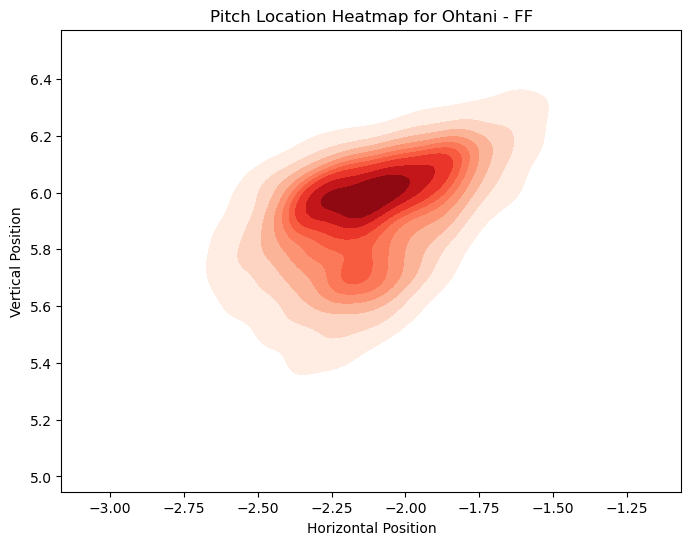

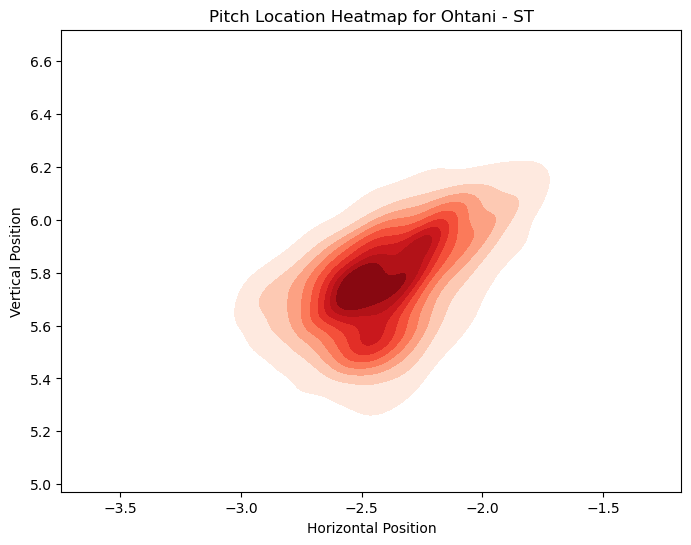

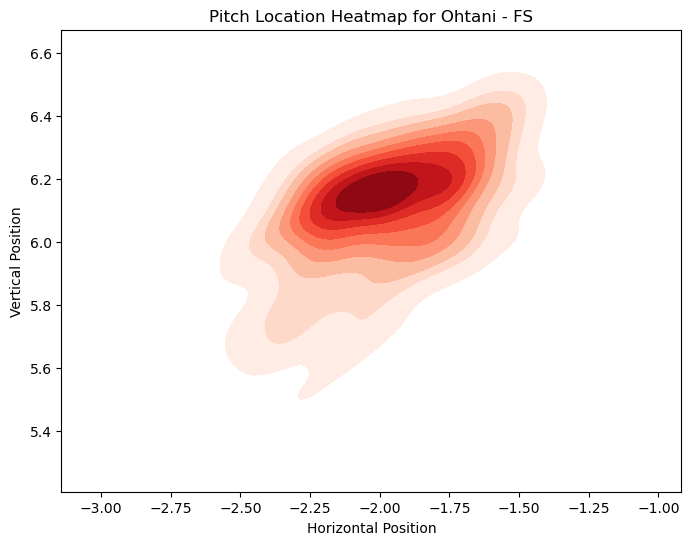

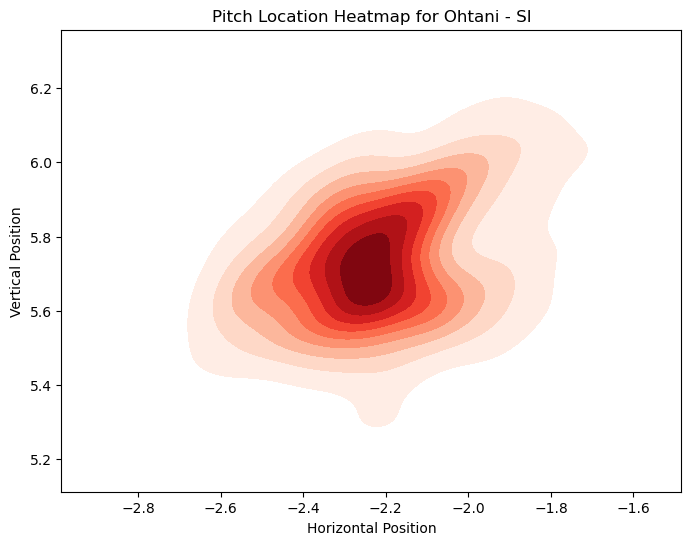

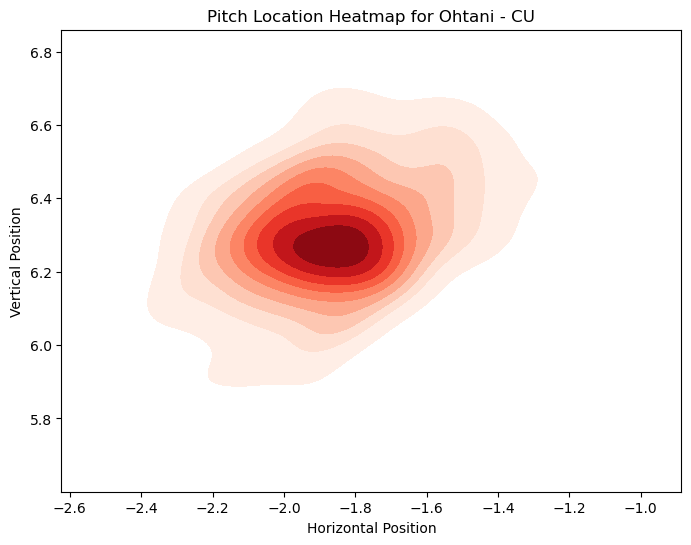

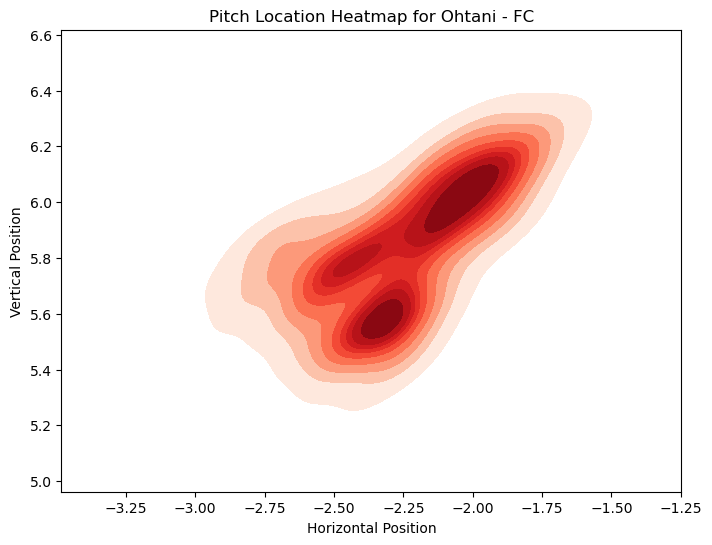

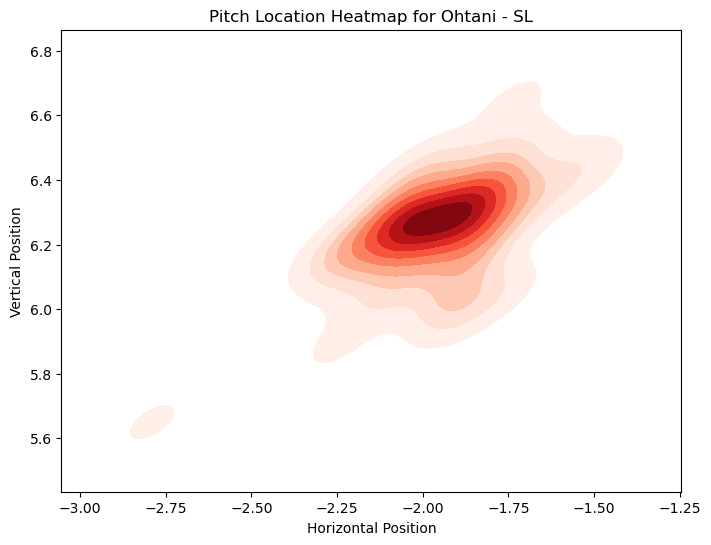

/tmp/ipykernel_570/3142549529.py:6: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.



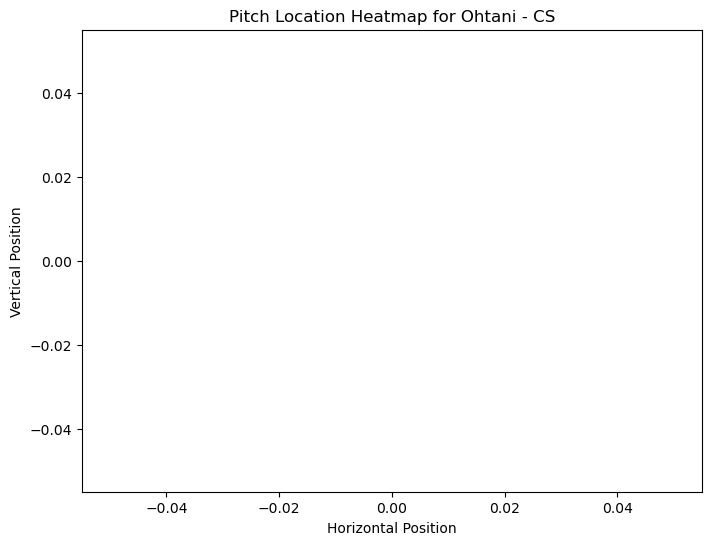

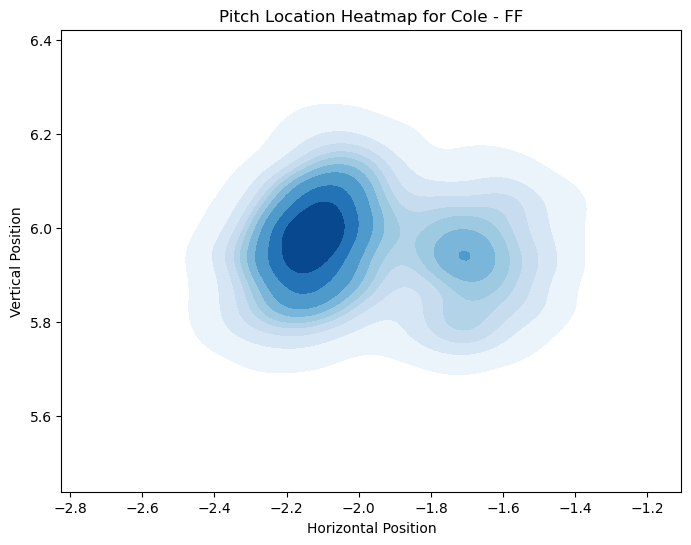

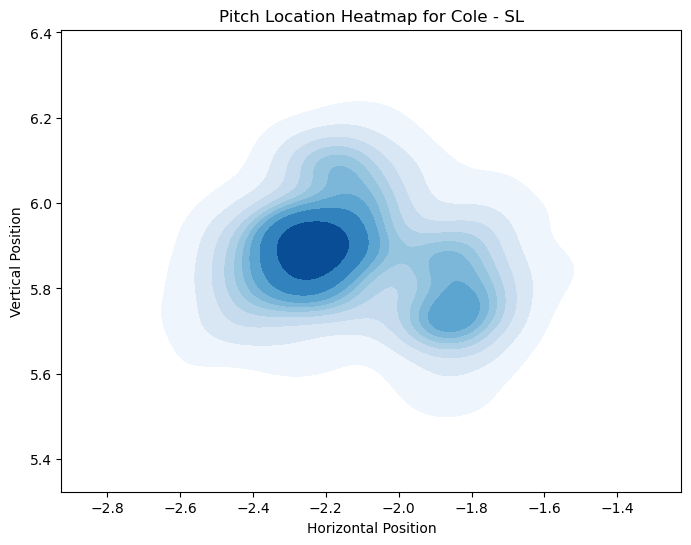

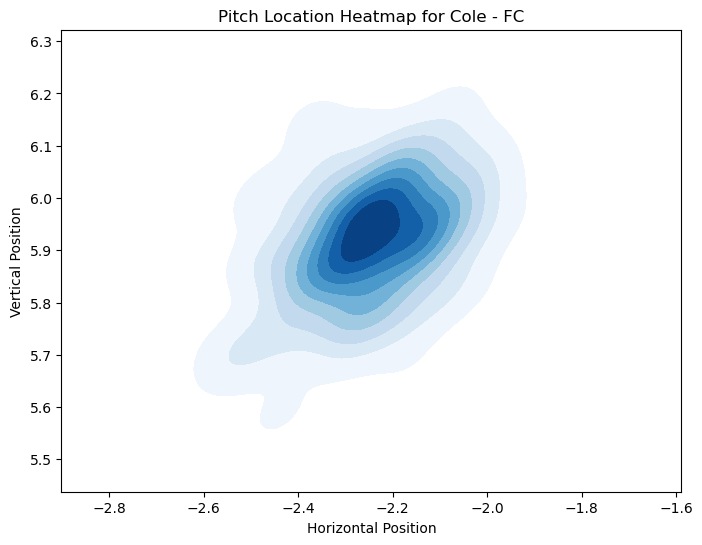

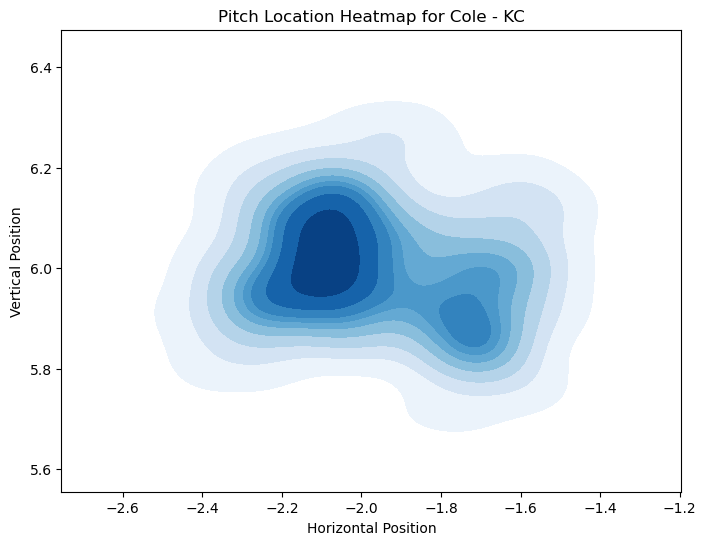

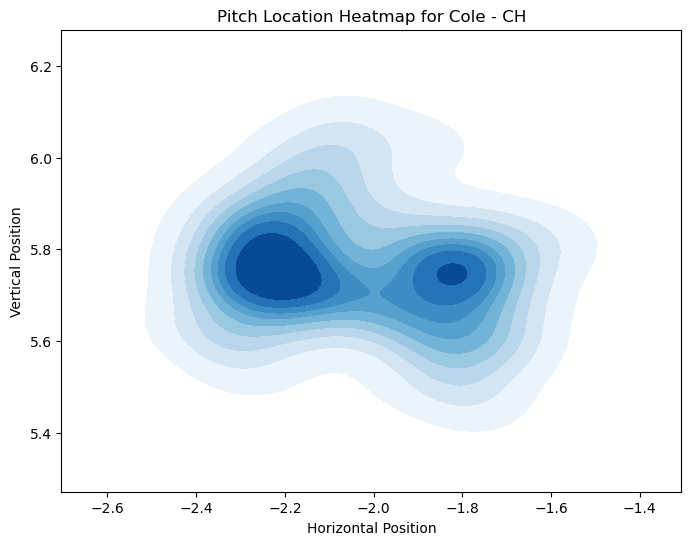

In [271]:
# Heatmaps of pitch locations for Ohtani

for pitch in Ohtani['pitch_type'].unique():
    plt.figure(figsize=(8, 6))
    pitch_data = Ohtani[Ohtani['pitch_type'] == pitch]
    sns.kdeplot(x=pitch_data['release_pos_x'], y=pitch_data['release_pos_z'], cmap='Reds', fill=True)
    plt.title(f'Pitch Location Heatmap for Ohtani - {pitch}')
    plt.xlabel('Horizontal Position')
    plt.ylabel('Vertical Position')
    plt.show()

# Heatmaps of pitch locations for Cole
for pitch in Cole['pitch_type'].unique():
    plt.figure(figsize=(8, 6))
    pitch_data = Cole[Cole['pitch_type'] == pitch]
    sns.kdeplot(x=pitch_data['release_pos_x'], y=pitch_data['release_pos_z'], cmap='Blues', fill=True)
    plt.title(f'Pitch Location Heatmap for Cole - {pitch}')
    plt.xlabel('Horizontal Position')
    plt.ylabel('Vertical Position')
    plt.show()


In [272]:
# Create a list of unique pitch types for both players
ohtani_pitch_types = Ohtani['pitch_type'].unique()
cole_pitch_types = Cole['pitch_type'].unique()
all_pitch_types = sorted(set(ohtani_pitch_types).union(cole_pitch_types))

# Define a function to plot the heatmaps
def plot_heatmaps(pitch_type):
    # Plot heatmap for Ohtani
    if pitch_type in ohtani_pitch_types:
        pitch_data_ohtani = Ohtani[Ohtani['pitch_type'] == pitch_type]
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.kdeplot(x=pitch_data_ohtani['release_pos_x'], y=pitch_data_ohtani['release_pos_z'], cmap='Reds', fill=True)
        plt.title(f'Pitch Location Heatmap for Ohtani - {pitch_type}')
        plt.xlabel('Horizontal Position')
        plt.ylabel('Vertical Position')
    
    # Plot heatmap for Cole
    if pitch_type in cole_pitch_types:
        pitch_data_cole = Cole[Cole['pitch_type'] == pitch_type]
        plt.subplot(1, 2, 2)
        sns.kdeplot(x=pitch_data_cole['release_pos_x'], y=pitch_data_cole['release_pos_z'], cmap='Blues', fill=True)
        plt.title(f'Pitch Location Heatmap for Cole - {pitch_type}')
        plt.xlabel('Horizontal Position')
        plt.ylabel('Vertical Position')
    
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for pitch types
pitch_type_dropdown = widgets.Dropdown(
    options=all_pitch_types,
    value=all_pitch_types[0],
    description='Pitch Type:',
)

# Use ipywidgets interact to update heatmaps based on dropdown selection
interact(plot_heatmaps, pitch_type=pitch_type_dropdown)


interactive(children=(Dropdown(description='Pitch Type:', options=('CH', 'CS', 'CU', 'FC', 'FF', 'FS', 'KC', '…

<function __main__.plot_heatmaps(pitch_type)>

In [273]:
# Filter the data for left and right-handed pitches for Ohtani
ohtani_left_data = Ohtani[Ohtani['p_throws'] == 'L']
ohtani_right_data = Ohtani[Ohtani['p_throws'] == 'R']

# Define a function to plot the heatmaps
def plot_ohtani_heatmaps(pitch_type):
    plt.figure(figsize=(14, 6))
    
    # Plot heatmap for left-handed pitches
    if pitch_type in ohtani_left_data['pitch_type'].unique():
        left_data = ohtani_left_data[ohtani_left_data['pitch_type'] == pitch_type]
        plt.subplot(1, 2, 1)
        sns.kdeplot(x=left_data['release_pos_x'], y=left_data['release_pos_z'], cmap='Reds', fill=True)
        plt.title(f'Ohtani - Left Handed - {pitch_type}')
        plt.xlabel('Horizontal Position')
        plt.ylabel('Vertical Position')
    
    # Plot heatmap for right-handed pitches
    if pitch_type in ohtani_right_data['pitch_type'].unique():
        right_data = ohtani_right_data[ohtani_right_data['pitch_type'] == pitch_type]
        plt.subplot(1, 2, 2)
        sns.kdeplot(x=right_data['release_pos_x'], y=right_data['release_pos_z'], cmap='Blues', fill=True)
        plt.title(f'Ohtani - Right Handed - {pitch_type}')
        plt.xlabel('Horizontal Position')
        plt.ylabel('Vertical Position')
    
    plt.tight_layout()
    plt.show()

# Create a list of unique pitch types for Ohtani
ohtani_pitch_types = Ohtani['pitch_type'].unique()

# Create a dropdown widget for pitch types
pitch_type_dropdown = widgets.Dropdown(
    options=ohtani_pitch_types,
    value=ohtani_pitch_types[0],
    description='Pitch Type:',
)

# Use ipywidgets interact to update heatmaps based on dropdown selection
interact(plot_ohtani_heatmaps, pitch_type=pitch_type_dropdown)


interactive(children=(Dropdown(description='Pitch Type:', options=('FF', 'ST', 'FS', 'SI', 'CU', 'FC', 'SL', '…

<function __main__.plot_ohtani_heatmaps(pitch_type)>

In [274]:
# Filter the data for left and right-handed pitches for Ohtani
ohtani_left_data = Ohtani[Ohtani['p_throws'] == 'L']
ohtani_right_data = Ohtani[Ohtani['p_throws'] == 'R']

# Define a function to plot the heatmaps including the batter's stand
def plot_ohtani_heatmaps(pitch_type):
    plt.figure(figsize=(18, 12))
    
    # Plot heatmap for left-handed pitches (Left-handed batter)
    if pitch_type in ohtani_left_data['pitch_type'].unique():
        left_data_left_stand = ohtani_left_data[(ohtani_left_data['pitch_type'] == pitch_type) & (ohtani_left_data['stand'] == 'L')]
        if len(left_data_left_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 1)
            sns.kdeplot(x=left_data_left_stand['release_pos_x'], y=left_data_left_stand['release_pos_z'], cmap='Reds', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Left')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 1)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Left (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    # Plot heatmap for left-handed pitches (Right-handed batter)
    if pitch_type in ohtani_left_data['pitch_type'].unique():
        left_data_right_stand = ohtani_left_data[(ohtani_left_data['pitch_type'] == pitch_type) & (ohtani_left_data['stand'] == 'R')]
        if len(left_data_right_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 2)
            sns.kdeplot(x=left_data_right_stand['release_pos_x'], y=left_data_right_stand['release_pos_z'], cmap='Reds', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Right')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 2)
            plt.title(f'Ohtani - Left Handed - {pitch_type} - Batter Right (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    # Plot heatmap for right-handed pitches (Left-handed batter)
    if pitch_type in ohtani_right_data['pitch_type'].unique():
        right_data_left_stand = ohtani_right_data[(ohtani_right_data['pitch_type'] == pitch_type) & (ohtani_right_data['stand'] == 'L')]
        if len(right_data_left_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 3)
            sns.kdeplot(x=right_data_left_stand['release_pos_x'], y=right_data_left_stand['release_pos_z'], cmap='Blues', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Left')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 3)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Left (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    # Plot heatmap for right-handed pitches (Right-handed batter)
    if pitch_type in ohtani_right_data['pitch_type'].unique():
        right_data_right_stand = ohtani_right_data[(ohtani_right_data['pitch_type'] == pitch_type) & (ohtani_right_data['stand'] == 'R')]
        if len(right_data_right_stand) > 1:  # Check if there are enough data points
            plt.subplot(2, 2, 4)
            sns.kdeplot(x=right_data_right_stand['release_pos_x'], y=right_data_right_stand['release_pos_z'], cmap='Blues', fill=True, warn_singular=False)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Right')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
        else:
            plt.subplot(2, 2, 4)
            plt.title(f'Ohtani - Right Handed - {pitch_type} - Batter Right (Not enough data)')
            plt.xlabel('Horizontal Position')
            plt.ylabel('Vertical Position')
    
    plt.tight_layout()
    plt.show()

# Create a list of unique pitch types for Ohtani
ohtani_pitch_types = Ohtani['pitch_type'].unique()

# Create a dropdown widget for pitch types
pitch_type_dropdown = widgets.Dropdown(
    options=ohtani_pitch_types,
    value=ohtani_pitch_types[0],
    description='Pitch Type:',
)

# Use ipywidgets interact to update heatmaps based on dropdown selection
interact(plot_ohtani_heatmaps, pitch_type=pitch_type_dropdown)

interactive(children=(Dropdown(description='Pitch Type:', options=('FF', 'ST', 'FS', 'SI', 'CU', 'FC', 'SL', '…

<function __main__.plot_ohtani_heatmaps(pitch_type)>

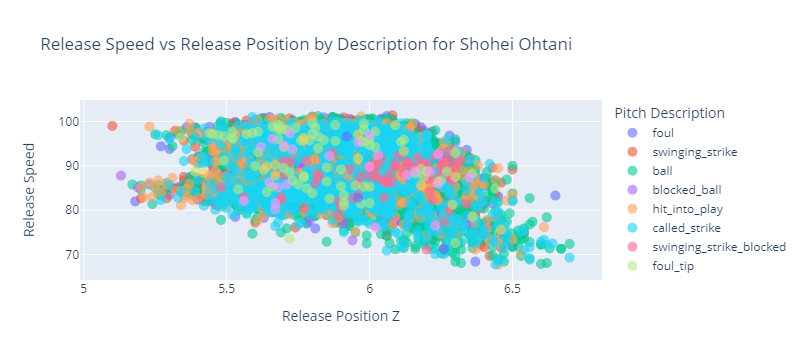

In [275]:
# Filter out rows with missing descriptions
filtered_df = Ohtani.dropna(subset=['description'])

# Create the interactive scatter plot
fig = px.scatter(
    filtered_df,
    x='release_pos_z',
    y='release_speed',
    color='description',
    title='Release Speed vs Release Position by Description for Shohei Ohtani',
    labels={
        'release_speed': 'Release Speed',
        'release_pos_z': 'Release Position Z',
        'description': 'Pitch Description'
    }
)

# Update layout to add hover interaction
fig.update_traces(marker=dict(size=10, opacity=0.6), 
                  selector=dict(mode='markers'))

# Add custom hover interaction
fig.update_layout(
    hovermode='closest',
    hoverlabel=dict(bgcolor="white", font_size=16)
)

fig.show()

In [276]:

# Create a list of unique pitch types for both players
ohtani_pitch_types = Ohtani['pitch_type'].unique()
cole_pitch_types = Cole['pitch_type'].unique()
all_pitch_types = sorted(set(ohtani_pitch_types).union(cole_pitch_types))

# Define a function to create 3D scatter plots
def plot_3d_heatmaps(pitch_type):
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]], subplot_titles=[f'Ohtani - {pitch_type}', f'Cole - {pitch_type}'])
    
    if pitch_type in ohtani_pitch_types:
        pitch_data_ohtani = Ohtani[Ohtani['pitch_type'] == pitch_type]
        fig.add_trace(
            go.Scatter3d(
                x=pitch_data_ohtani['release_pos_x'], 
                y=pitch_data_ohtani['release_pos_z'], 
                z=pitch_data_ohtani['release_speed'], 
                mode='markers',
                marker=dict(size=4, color=pitch_data_ohtani['release_speed'], colorscale='Reds', opacity=0.8),
                name=f'Ohtani - {pitch_type}'
            ),
            row=1, col=1
        )
    
    if pitch_type in cole_pitch_types:
        pitch_data_cole = Cole[Cole['pitch_type'] == pitch_type]
        fig.add_trace(
            go.Scatter3d(
                x=pitch_data_cole['release_pos_x'], 
                y=pitch_data_cole['release_pos_z'], 
                z=pitch_data_cole['release_speed'], 
                mode='markers',
                marker=dict(size=4, color=pitch_data_cole['release_speed'], colorscale='Blues', opacity=0.8),
                name=f'Cole - {pitch_type}'
            ),
            row=1, col=2
        )
    
    fig.update_layout(
        height=600, width=1200,
        title_text=f'3D Pitch Location and Speed: {pitch_type}',
        showlegend=False
    )
    
    fig.show()

# Create a dropdown widget for pitch types
pitch_type_dropdown = Dropdown(
    options=all_pitch_types,
    value=all_pitch_types[0],
    description='Pitch Type:',
)

# Use ipywidgets interact to update 3D plots based on dropdown selection
interact(plot_3d_heatmaps, pitch_type=pitch_type_dropdown)


interactive(children=(Dropdown(description='Pitch Type:', options=('CH', 'CS', 'CU', 'FC', 'FF', 'FS', 'KC', '…

<function __main__.plot_3d_heatmaps(pitch_type)>

In [341]:
import pandas as pd
import plotly.graph_objects as go

# Filter out rows with missing descriptions
filtered_df = Ohtani.dropna(subset=['description'])

# Create the interactive 3D scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=filtered_df['release_pos_x'],
    y=filtered_df['release_pos_z'],
    z=filtered_df['release_speed'],
    mode='markers',
    marker=dict(
        size=5,
        color=filtered_df['release_speed'], # Set color to release speed for gradient
        colorscale='Viridis', # Choose a colorscale
        opacity=0.8
    ),
    text=filtered_df['description'], # Use pitch description for hover text
    hoverinfo='text'
))

# Update layout to add title and labels
fig.update_layout(
    title='3D Scatter Plot of Release Speed and Position for Shohei Ohtani',
    scene=dict(
        xaxis_title='Release Position X',
        yaxis_title='Release Position Z',
        zaxis_title='Release Speed'
    ),
    hovermode='closest'
)

# Show the plot
fig.show()


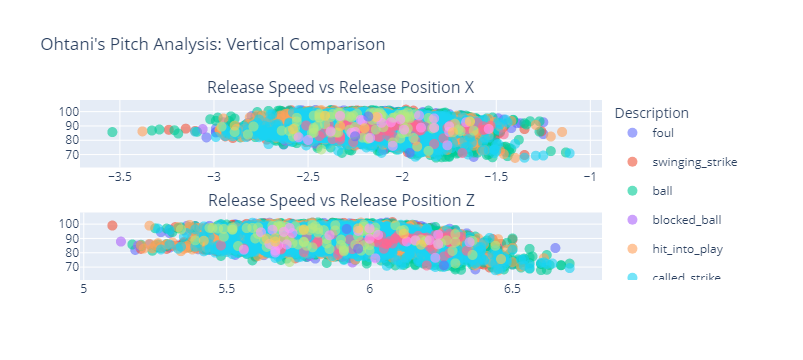

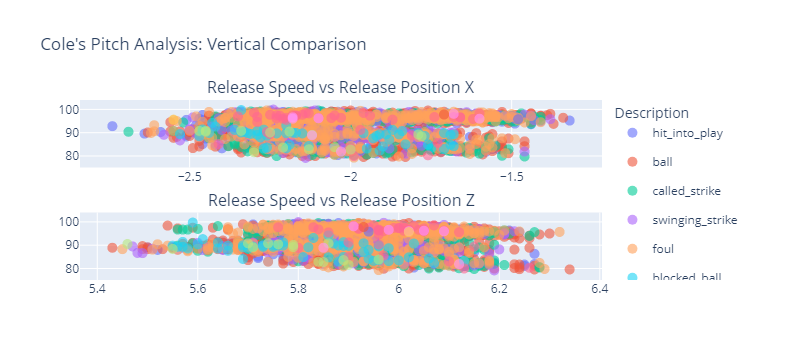

In [278]:


filtered_df = Ohtani.dropna(subset=['description'])
filtered_df = Ohtani.dropna(subset=['description'])

fig = make_subplots(rows=2, cols=1, subplot_titles=("Release Speed vs Release Position X", "Release Speed vs Release Position Z"))


fig_px = px.scatter(
    filtered_df,
    x='release_pos_x',
    y='release_speed',
    color='description',
    labels={
        'release_speed': 'Release Speed',
        'release_pos_x': 'Release Position X',
        'description': 'Pitch Description'
    }
)

fig_pz = px.scatter(
    filtered_df,
    x='release_pos_z',
    y='release_speed',
    color='description',
    labels={
        'release_speed': 'Release Speed',
        'release_pos_z': 'Release Position Z',
        'description': 'Pitch Description'
    }
)


for trace in fig_px.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig_pz.data:
    trace.showlegend = False
    fig.add_trace(trace, row=2, col=1)


fig.update_traces(marker=dict(size=10, opacity=0.6), selector=dict(mode='markers'))
fig.update_layout(hovermode='closest', hoverlabel=dict(bgcolor="white", font_size=16), legend_title_text='Description')


fig.update_layout(title_text="Ohtani's Pitch Analysis: Vertical Comparison", showlegend=True)


fig.show()
filtered_df = Cole.dropna(subset=['description'])

fig = make_subplots(rows=2, cols=1, subplot_titles=("Release Speed vs Release Position X", "Release Speed vs Release Position Z"))


fig_px = px.scatter(
    filtered_df,
    x='release_pos_x',
    y='release_speed',
    color='description',
    labels={
        'release_speed': 'Release Speed',
        'release_pos_x': 'Release Position X',
        'description': 'Pitch Description'
    }
)

fig_pz = px.scatter(
    filtered_df,
    x='release_pos_z',
    y='release_speed',
    color='description',
    labels={
        'release_speed': 'Release Speed',
        'release_pos_z': 'Release Position Z',
        'description': 'Pitch Description'
    }
)


for trace in fig_px.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig_pz.data:
    trace.showlegend = False
    fig.add_trace(trace, row=2, col=1)


fig.update_traces(marker=dict(size=10, opacity=0.6), selector=dict(mode='markers'))
fig.update_layout(hovermode='closest', hoverlabel=dict(bgcolor="white", font_size=16), legend_title_text='Description')


fig.update_layout(title_text="Cole's Pitch Analysis: Vertical Comparison", showlegend=True)


fig.show()

In [279]:


# Filter out rows with missing descriptions
filtered_df = Ohtani.dropna(subset=['description'])

# Unique pitch types for the dropdown
pitch_types = filtered_df['pitch_type'].unique()

# Function to create the plot based on selected pitch type
def plot_pitch_analysis(pitch_type):
    filtered_data = filtered_df[filtered_df['pitch_type'] == pitch_type]
    
    fig = make_subplots(rows=2, cols=1, subplot_titles=("Release Speed vs Release Position X", "Release Speed vs Release Position Z"))
    
    fig_px = px.scatter(
        filtered_data,
        x='release_pos_x',
        y='release_speed',
        color='description',
        labels={
            'release_speed': 'Release Speed',
            'release_pos_x': 'Release Position X',
            'description': 'Pitch Description'
        }
    )
    
    fig_pz = px.scatter(
        filtered_data,
        x='release_pos_z',
        y='release_speed',
        color='description',
        labels={
            'release_speed': 'Release Speed',
            'release_pos_z': 'Release Position Z',
            'description': 'Pitch Description'
        }
    )
    
    for trace in fig_px.data:
        fig.add_trace(trace, row=1, col=1)
    
    for trace in fig_pz.data:
        trace.showlegend = False
        fig.add_trace(trace, row=2, col=1)
    
    fig.update_traces(marker=dict(size=10, opacity=0.6), selector=dict(mode='markers'))
    fig.update_layout(hovermode='closest', hoverlabel=dict(bgcolor="white", font_size=16), legend_title_text='Description')
    fig.update_layout(title_text=f"Ohtani's Pitch Analysis: {pitch_type} Comparison", showlegend=True)
    
    fig.show()

# Create a dropdown widget for pitch types
pitch_type_dropdown = Dropdown(
    options=pitch_types,
    value=pitch_types[0],
    description='Pitch Type:',
)

# Use ipywidgets interact to update the plot based on dropdown selection
interact(plot_pitch_analysis, pitch_type=pitch_type_dropdown)


interactive(children=(Dropdown(description='Pitch Type:', options=('FF', 'ST', 'FS', 'SI', 'CU', 'FC', 'SL', '…

<function __main__.plot_pitch_analysis(pitch_type)>

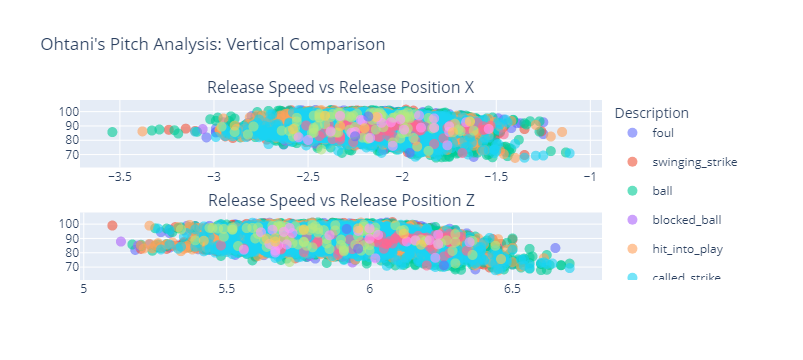

In [280]:


filtered_df = Ohtani.dropna(subset=['description'])

fig = make_subplots(rows=2, cols=1, subplot_titles=("Release Speed vs Release Position X", "Release Speed vs Release Position Z"))


fig_px = px.scatter(
    filtered_df,
    x='release_pos_x',
    y='release_speed',
    color='description',
    labels={
        'release_speed': 'Release Speed',
        'release_pos_x': 'Release Position X',
        'description': 'Pitch Description'
    }
)

fig_pz = px.scatter(
    filtered_df,
    x='release_pos_z',
    y='release_speed',
    color='description',
    labels={
        'release_speed': 'Release Speed',
        'release_pos_z': 'Release Position Z',
        'description': 'Pitch Description'
    }
)


for trace in fig_px.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig_pz.data:
    trace.showlegend = False
    fig.add_trace(trace, row=2, col=1)


fig.update_traces(marker=dict(size=10, opacity=0.6), selector=dict(mode='markers'))
fig.update_layout(hovermode='closest', hoverlabel=dict(bgcolor="white", font_size=16), legend_title_text='Description')


fig.update_layout(title_text="Ohtani's Pitch Analysis: Vertical Comparison", showlegend=True)


fig.show()

In [281]:


# Load your data and filter rows with missing descriptions
filtered_df = Ohtani.dropna(subset=['description'])

# Unique pitch types for the dropdown
pitch_types = filtered_df['pitch_type'].unique()

# Function to create the plot based on selected pitch type
def plot_pitch_analysis(pitch_type):
    # Filter data for the selected pitch type
    filtered_data = filtered_df[filtered_df['pitch_type'] == pitch_type]

    fig = make_subplots(rows=2, cols=1, subplot_titles=("Release Speed vs Release Position X", "Release Speed vs Release Position Z"))

    # Plot for Release Position X vs Speed
    fig_px = px.scatter(
        filtered_data,
        x='release_pos_x',
        y='release_speed',
        color='description',
        labels={
            'release_speed': 'Release Speed',
            'release_pos_x': 'Release Position X',
            'description': 'Pitch Description'
        }
    )

    # Plot for Release Position Z vs Speed
    fig_pz = px.scatter(
        filtered_data,
        x='release_pos_z',
        y='release_speed',
        color='description',
        labels={
            'release_speed': 'Release Speed',
            'release_pos_z': 'Release Position Z',
            'description': 'Pitch Description'
        }
    )

    # Add plots to subplots
    for trace in fig_px.data:
        fig.add_trace(trace, row=1, col=1)

    for trace in fig_pz.data:
        trace.showlegend = False
        fig.add_trace(trace, row=2, col=1)

    # Update plot settings
    fig.update_traces(marker=dict(size=10, opacity=0.6))
    fig.update_layout(
        hovermode='closest',
        hoverlabel=dict(bgcolor="white", font_size=16),
        legend_title_text='Description',
        title_text=f"Ohtani's Pitch Analysis: {pitch_type} Comparison",
        showlegend=True
    )

    fig.show()

# Create a dropdown widget for pitch types
pitch_type_dropdown = Dropdown(
    options=pitch_types,
    value=pitch_types[0],
    description='Pitch Type:',
)

# Use ipywidgets interact to update the plot based on dropdown selection
interact(plot_pitch_analysis, pitch_type=pitch_type_dropdown)


interactive(children=(Dropdown(description='Pitch Type:', options=('FF', 'ST', 'FS', 'SI', 'CU', 'FC', 'SL', '…

<function __main__.plot_pitch_analysis(pitch_type)>

In [282]:
filtered_df = Cole.dropna(subset=['description'])

# Unique pitch types for the dropdown
pitch_types = filtered_df['pitch_type'].unique()

# Function to create the plot based on selected pitch type
def plot_pitch_analysis(pitch_type):
    filtered_data = filtered_df[filtered_df['pitch_type'] == pitch_type]
    
    fig = make_subplots(rows=2, cols=1, subplot_titles=("Release Speed vs Release Position X", "Release Speed vs Release Position Z"))
    
    fig_px = px.scatter(
        filtered_data,
        x='release_pos_x',
        y='release_speed',
        color='description',
        labels={
            'release_speed': 'Release Speed',
            'release_pos_x': 'Release Position X',
            'description': 'Pitch Description'
        }
    )
    
    fig_pz = px.scatter(
        filtered_data,
        x='release_pos_z',
        y='release_speed',
        color='description',
        labels={
            'release_speed': 'Release Speed',
            'release_pos_z': 'Release Position Z',
            'description': 'Pitch Description'
        }
    )
    
    for trace in fig_px.data:
        fig.add_trace(trace, row=1, col=1)
    
    for trace in fig_pz.data:
        trace.showlegend = False
        fig.add_trace(trace, row=2, col=1)
    
    fig.update_traces(marker=dict(size=10, opacity=0.6), selector=dict(mode='markers'))
    fig.update_layout(hovermode='closest', hoverlabel=dict(bgcolor="white", font_size=16), legend_title_text='Description')
    fig.update_layout(title_text=f"Cole's Pitch Analysis: {pitch_type} Comparison", showlegend=True)
    
    fig.show()

# Create a dropdown widget for pitch types
pitch_type_dropdown = Dropdown(
    options=pitch_types,
    value=pitch_types[0],
    description='Pitch Type:',
)

# Use ipywidgets interact to update the plot based on dropdown selection
interact(plot_pitch_analysis, pitch_type=pitch_type_dropdown)

interactive(children=(Dropdown(description='Pitch Type:', options=('FF', 'SL', 'FC', 'KC', 'CH'), value='FF'),…

<function __main__.plot_pitch_analysis(pitch_type)>

In [283]:



def plot_3d_pitch_speed_distribution(pitchers):
    fig = go.Figure()

    # Colors
    cmap = matplotlib.colormaps['tab20']
    pitch_types = {pt for df in pitchers.values() for pt in df['pitch_type'].unique()}
    colors = {pt: cmap(i / len(pitch_types)) for i, pt in enumerate(pitch_types)}

    # Plot data
    for i, (pitcher_name, df) in enumerate(pitchers.items()):
        for pitch_type, color in colors.items():
            subset = df[df['pitch_type'] == pitch_type]
            if not subset.empty:
                fig.add_trace(go.Scatter3d(
                    x=subset['release_speed'],
                    y=[pitcher_name] * len(subset),
                    z=[pitch_type] * len(subset),
                    mode='markers',
                    marker=dict(
                        size=5,
                        color='rgba({}, {}, {}, {})'.format(*[round(c*255) for c in matplotlib.colors.to_rgba(color)]),
                        opacity=0.6
                    ),
                    name=f'{pitcher_name} - {pitch_type}'
                ))

    # Update the layout
    fig.update_layout(
        scene=dict(
            xaxis_title='Release Speed',
            yaxis_title='Pitcher',
            zaxis_title='Pitch Type'
        ),
        title='3D Scatter of Pitch Speed Distribution by Pitch Type and Pitcher'
    )
    fig.show()

# Example usage
plot_3d_pitch_speed_distribution(pitchers)


In [284]:
import plotly.graph_objects as go
import pandas as pd

# Assume Ohtani and Cole dataframes are preloaded into variables 'Ohtani' and 'Cole'
# The dataframes should have columns for 'release_speed', 'release_pos_x', and 'release_pos_z'

def plot_3d_strikes_comparison(Ohtani, Cole):
    # Filter for strikes in each dataset
    # Assuming 'description' column includes information on whether the pitch was a strike
    Ohtani_strikes = Ohtani[Ohtani['description'].str.contains('strike')]
    Cole_strikes = Cole[Cole['description'].str.contains('strike')]

    fig = go.Figure()

    # Add Ohtani's strikes to the plot
    fig.add_trace(go.Scatter3d(
        x=Ohtani_strikes['release_pos_x'],
        y=Ohtani_strikes['release_pos_z'],
        z=Ohtani_strikes['release_speed'],
        mode='markers',
        marker=dict(
            size=3,
            color='blue',  # Color for Ohtani
            opacity=0.6
        ),
        name='Ohtani Strikes'
    ))

    # Add Cole's strikes to the plot
    fig.add_trace(go.Scatter3d(
        x=Cole_strikes['release_pos_x'],
        y=Cole_strikes['release_pos_z'],
        z=Cole_strikes['release_speed'],
        mode='markers',
        marker=dict(
            size=3,
            color='red',  # Color for Cole
            opacity=0.6
        ),
        name='Cole Strikes'
    ))

    # Update the layout
    fig.update_layout(
        scene=dict(
            xaxis_title='Release Position X',
            yaxis_title='Release Position Z',
            zaxis_title='Release Speed',
            xaxis=dict(backgroundcolor="rgb(200, 200, 230)"),
            yaxis=dict(backgroundcolor="rgb(230, 200,230)"),
            zaxis=dict(backgroundcolor="rgb(230, 230,200)")
        ),
        title='3D Scatter Plot of Ohtani vs Cole Strikes'
    )

    fig.show()

# Example usage (replace 'Ohtani' and 'Cole' with your actual DataFrame variables)
plot_3d_strikes_comparison(Ohtani, Cole)
